In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import numpy as np
from scipy.stats import norm
from dataclasses import dataclass

from utils import *
from config import *


## How does this work?

This notebook executes a power analysis when the goal is to run discovery / elasticities tests for customer areas. Test setup is based on what was shared in the [Pricing Community VII](https://docs.google.com/presentation/d/17DcFaQTIVhFMLIZcWUR7lKg6VU-bidehiqQxXSUGJxQ/edit) regarding customer location. Since the analysis is not at the city level but rather at areas, we need to ensure that all areas must meet the sample size. 

The methodology here proposes an algorithm that takes area shapes, some session data and outputs a smaller, consolidated list of areas that should be analyzed together. The algorithm works assuming that if the smallest area, defined by the number of users making sessions, meets the sample size, all bigger areas will too. If an area does not meet the sample size, it must be merged with another area. The step-by-step process is the following:

- Load required data from BQ -> area shapes + session, conversion data at the user level + area indicator
- Initialize the tests parameters (n_variants, mde, alpha, power) plus a area mapping
    - The area mapping is extremely important. It keeps a log of which area should be merged with another one. For example, at iteration 0 we got the following mapping {"A":"A", "B":"B", "C":"C"}.\
      In the first iteration, it was decided that area "C" should be added to "A". thus, the new mapping is: {"A":"A", "B":"B", "C":"A"}.
- aggregate user level data to find the smallest area
- Using the aggregated data, find the smallest neighbor for each area.
- Calculate the required sample size for the intented MDE and compare it to the number of users in the area.
  - if the area has more user. Amazing, algorithm will stop. 
  - otherwise, merge the area to their smallest neighbor.
    - In the case the area doesn't have any neighbor, it will be merged with the next overall smallest area.
- Update the area mappings

Repeat until the algorithm has managed to find all areas that meet the sample size or it has exhausted all iterations.




### TO-DO
- ~~Parametrize sql arguments to allow different inputs~~ 
- Wrap the while in a function or what? 
- Persist aggregated shapes (BQ table, csv?)
- Remove non-exis

# Code

## Load data

In [4]:
connector = Connector(**BIGQUERY_CONFIG)

In [5]:
# @dataclass
# class QueryArgs:
#     filename:str 
#     params: dict[str, any]


# class QueryHandler:
#     folder = "queries"

#     @classmethod
#     def build_query(cls, query_args:QueryArgs) -> str:
#         path = os.path.join(cls.folder, query_args.filename)
#         with open(path, "r") as file:
#             query = file.read().format(**query_args.params)
#         return query 
    




In [6]:
istanbul_inputs = {
    "shape_query" : QueryArgs(
        filename = "area-shapes.sql",
        params = {
            "country_code":"tr",
            "city":"Istanbul"
        }
    )

    , "session_query" : QueryArgs(
        filename = "cvr-per-area.sql",
        params = {
            "country_code":"tr",
            "city":"Istanbul",
            "entity_id":"YS_TR",
            "weeks_ago":3,
            "city_id":1,
            "asa_ids":[334]
        }
    )

    , "city_query" : QueryArgs(
        filename = "city-dh-shape.sql",
        params = {
            "entity_id":"YS_TR",
            "city_id":1
        }
    )
}


athens_inputs = {
    "shape_query" : QueryArgs(
        filename = "area-shapes.sql",
        params = {
            "country_code":"gr",
            "city":"Attica"
        }
    )

    , "session_query" : QueryArgs(
        filename = "cvr-per-area.sql",
        params = {
            "country_code":"gr",
            "city":"Attica",
            "entity_id":"EF_GR",
            "weeks_ago":1,
            "city_id":1
        }
    )

    , "city_query" : QueryArgs(
        filename = "city-dh-shape.sql",
        params = {
            "entity_id":"EF_GR",
            "city_id":1
        }
    )
}


santa_cruz_input = {
    "shape_query" : QueryArgs(
        filename = "area-shapes.sql",
        params = {
            "country_code":"bo",
            "city":"Santa Cruz"
        }
    )

    , "session_query" : QueryArgs(
        filename = "cvr-per-area.sql",
        params = {
            "country_code":"bo",
            "city":"Santa Cruz",
            "entity_id":"PY_BO",
            "weeks_ago":1,
            "city_id":1
        }
    )

    , "city_query" : QueryArgs(
        filename = "city-dh-shape.sql",
        params = {
            "entity_id":"PY_BO",
            "city_id":1
        }
    )
}

In [7]:
session_data = connector.get_df_from_query(QueryHandler.build_query(istanbul_inputs["session_query"]))

area_shapes = (
    connector
    .get_df_from_query(QueryHandler.build_query(istanbul_inputs["shape_query"]))
    .pipe(convert_to_geopandas, "area_shape")
    .drop(columns=["area_shape"])
)

city_dh_shape = (
    connector
    .get_df_from_query(QueryHandler.build_query(istanbul_inputs["city_query"]))
    .pipe(convert_to_geopandas, "city_shape")
    .drop(columns=["city_shape"])
)


Job ID 8781a0f0-a20d-4e7a-a1bb-d08106f10927 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
Job ID a0abf23f-06bc-44eb-88ef-b6b998b3415e successfully executed: 100%|██████████|
Downloading: 100%|██████████|
Job ID 0d29812d-0a06-4f51-87bc-63dd9ab43936 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


##  Utils

In [8]:
# @dataclass
# class DeltaParameters:
#     """Holds the parameters relevant to delta method variance.
#     more info here: https://arxiv.org/abs/2305.16459

#     As a general definition
#     u_s -> mean of sessions per user
#     var_s -> variance of avg sessions per user
#     u_n -> mean of transactions per user
#     var_n -> variance of avg transactions per user
#     covar_sn -> coviriance between transactions and sessions
#     """
#     u_s:float
#     u_n:float 
#     var_s:float 
#     var_n:float 
#     covar_sn:float 


# @dataclass
# class PowerInputs:
#     """Class to hold default inputs for power analysis. 
#     As a note, MDE must be ABSOLUTE
#     """
#     mde:float 
#     alpha:float = 0.05
#     power:float = 0.8
    

# def aggregate_detail_data(df:pd.DataFrame, session_col:str, conversion_col:str) -> DeltaParameters:
#     """Take a dataframe that holds information at the randomization level (e.g user) and 
#     calculate the variance/averages parameters used in the delta method.

#     Args:
#         df (pd.DataFrame): _description_
#         session_col (str): _description_
#         conversion_col (str): _description_

#     Returns:
#         DeltaParameters: _description_
#     """
#     params =  {
#             "u_s": df[session_col].mean()
#             , "u_n": df[conversion_col].mean()
#             , "var_s": df[session_col].var()
#             , "var_n":df[conversion_col].var()
#             , "covar_sn":df[session_col].cov(df[conversion_col])
#         }
#     return DeltaParameters(**params)

# def calculate_h(params:DeltaParameters) -> float:
#     """Calculate the factor h which is a correction of the variance for ratio metrics 
#     used in the delta method. More info here https://arxiv.org/abs/2305.16459

#     Args:
#         params (DeltaParameters): _description_

#     Returns:
#         float: _description_
#     """
#     denom = pow(params.u_n,2)
#     num = params.var_s - 2*params.covar_sn*(params.u_s/params.u_n) + params.var_n* (pow(params.u_s,2) / pow(params.u_n,2))
#     # print(f"num: {num}, denom: {denom}")
#     return num / denom

# def calculate_sample_size(delta_params: DeltaParameters, power_inputs:PowerInputs) -> float:
#     """Calculate number of users (sample size) using the delta method.
#     Method details are in this paper: https://arxiv.org/abs/2305.16459

#     As a summary, the delta method uses a corrected formula to get
#     the correct variance in the case sessions are correlated. This correlation usually happens
#     experiment randomizes on users but CVR is on session level.

#     Args:
#         delta_params (DeltaParameters): _description_
#         power_inputs (PowerInputs): _description_

#     Returns:
#         float: _description_
#     """
#     h = calculate_h(delta_params)
#     k = ( 2 * h * pow(abs(norm.ppf(power_inputs.alpha/2)) + norm.ppf(power_inputs.power), 2) ) / pow(power_inputs.mde, 2)
#     return k


# test function
# params = DeltaParameters(u_s=2.6, u_n=4.2, var_s=10.3, var_n=12.7, covar_sn=10.1)
# power_inputs = PowerInputs(mde=0.05)
# calculate_sample_size(params, power_inputs)

In [9]:
# def update_area_mappings(area_mapping:dict, current_area:str, next_area:str) -> dict[str, str]:
#     """This function update the mapping between the area and the group they get added to.
#     The idea of the mapping is to change the value of a given key. At the first iteration,
#     key and value are the same, i.e, the area name. As iterations goes on an smaller areas
#     get joined to other, the value will change to reference the area they're added to. 

#     For example, at iteration 0 we got the following mapping {"A":"A", "B":"B", "C":"C"}.
#     In the first iteration, it was decided that area "C" should be added to add, this function
#     should return the following dictionary: {"A":"A", "B":"B", "C":"A"}.

#     Args:
#         area_mapping (dict): _description_
#         current_area (str): _description_
#         next_area (str): _description_

#     Returns:
#         dict[str, list[str]]: _description_
#     """
#     # replace the current key value for the next area
#     area_mapping[current_area] = next_area
#     return {key:val.replace(current_area, next_area) for key, val in area_mapping.items()}


# def aggregate_user_data_per_area(df: pd.DataFrame) -> pd.DataFrame:
#         """This functions aggregate the input data, which is on user level
#         and calculate aggregated metrics at the area level

#         Args:
#             df (pd.DataFrame): _description_
#             agg_col (str): _description_

#         Returns:
#             pd.DataFrame: _description_
#         """
#         return (
#                 df
#                 .groupby( ["area_map"], as_index=False)
#                 .agg(
#                         avg_sessions = ("n_sessions", "mean")
#                         ,  avg_conversions = ("n_conversions", "mean")
#                         ,  total_session = ("n_sessions", "sum")
#                         ,  total_conversion = ("n_conversions", "sum")
#                         ,  n_users = ("perseus_client_id", "count")
#                 )
#                 .sort_values(by="n_users", ascending=True)
#         )

# def aggregate_shape_data_per_area(df:gpd.GeoDataFrame, area_mapping:dict[str,str]) -> gpd.GeoDataFrame:
#         """This function is used to obtain the combined polygon shape of areas that has been merged.
#         The area_mapping argument keeps track of such mapping from the original/detailed areas to the 
#         combined ones. The result is another geopandas dataframe but with only the combined areas names and shapes

#         Args:
#             df (gpd.GeoDataFrame): _description_
#             area_mapping (dict[str,str]): _description_

#         Returns:
#             gpd.GeoDataFrame: _description_
#         """
#         return (
#                 df
#                 .assign(
#                         area_map = lambda df: df.area_name.map(area_mapping)
#                 )
#                 .dissolve(by="area_map", aggfunc="sum")
#                 .reset_index()
#         )

# def get_neighbors_from_shapes(shapes_df:gpd.GeoDataFrame, area_df:pd.DataFrame) -> pd.DataFrame:
#         """This functions calculate the smallest neighbor for each area. A neighbor is defined as two polygons
#         sharing a common border. Smallest is defined in terms of number of users each area has.

#         Args:
#             shapes_df (gpd.GeoDataFrame): _description_
#             area_df (pd.DataFrame): _description_

#         Returns:
#             pd.DataFrame: _description_
#         """

#         return (
#                 shapes_df
#                 .sjoin(shapes_df, how="left", predicate="touches")
#                 [["area_map_left", "area_map_right"]]
#                 .rename(columns={"area_map_left":"area_map", "area_map_right":"neighbor_name"})
#                 .merge(area_df, left_on="neighbor_name", right_on="area_map", suffixes=(None, "_y"))
#                 [["area_map", "neighbor_name", "n_users"]]
#                 .pipe(row_number, partition_cols=["area_map"], sort_col="n_users", col_name="neighbor_rank")
#         )

## Workflow

In [15]:
power_params = PowerParams(mde=0.005, alpha=0.05, power=0.8, n_variants=5)

it_df = (
    session_data
    .copy()
)

it_shapes = (
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
)

area_mapping = {x:x for x in it_shapes.area_name.unique()}

i = 0
n_it = 1

while i < n_it:
    # update data with current mapping
    it_df = (it_df 
            .assign(area_map = lambda df: df.area_name.map(area_mapping))  
    )

    agg_data = (
        it_df
        .pipe(aggregate_user_data_per_area)
    )

    agg_shapes = (
        it_shapes
        .pipe(aggregate_shape_data_per_area, area_mapping)
    )

    # plot current progress at each n iteration
    # if i % 4 == 0:
    #     fig, ax = plt.subplots(1,1)
    #     sns.barplot(agg_data, y="n_users", x="area_map", ax=ax)
    #     ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

    #     ax = agg_shapes.plot(column="area_map")
    #     ax.set_axis_off()
    #     plt.show()


    neighbors = (
            agg_shapes
            .pipe(get_neighbors_from_shapes, agg_data)
    )


    # calculate sample size of the current area
    # upadte mapping if needed

    current_area = (
        agg_data
        .iloc[0]
    )

    current_area_params = (
        it_df
        .query(f"area_map=='{current_area.area_map}'")
        .pipe(aggregate_ratio_data, "n_sessions", "n_conversions")
    )

    sample_size = calculate_delta_method_sample_size(current_area_params, power_params)

    if sample_size * power_params.n_variants > current_area.n_users:
        area_neighbors = (
            neighbors
            .query(f"area_map=='{current_area.area_map}'")
            .sort_values(by=["neighbor_rank"])
        )
        if area_neighbors.empty:
            # in case the current area dont have neighbor, we use the overall next smalles
            smallest_neighbor = agg_data.iloc[1].area_map
        else:
            smallest_neighbor = area_neighbors.iloc[0].neighbor_name

        area_mapping = update_area_mappings(area_mapping, current_area.area_map, smallest_neighbor)
       
        print(f"iteration {i}")
        print("Current Smallest Area")
        print(current_area)
        print()

        print(f"Total Sample size: {sample_size*power_params.n_variants:.0f}, Area size: {current_area.n_users}")
        print(f"Area {current_area.area_map} to be merged with next neighbor: {smallest_neighbor}")
        print(f"{len(set(area_mapping.values()))} unique areas")
        print()

        i += 1

    else:
        print("Sample size has been reached!")
        print(f"Total Sample size: {sample_size*power_params.n_variants:.0f}, Area size: {current_area.n_users}")
        print(f"{len(set(area_mapping.values()))} unique areas")
        print()

        break



iteration 0
Current Smallest Area
area_map            Çekmekoy
avg_sessions        3.617919
avg_conversions      0.41109
total_session          42279
total_conversion        4804
n_users                11686
Name: 32, dtype: object

Total Sample size: 175040, Area size: 11686
Area Çekmekoy to be merged with next neighbor: Beykoz
35 unique areas



## Output

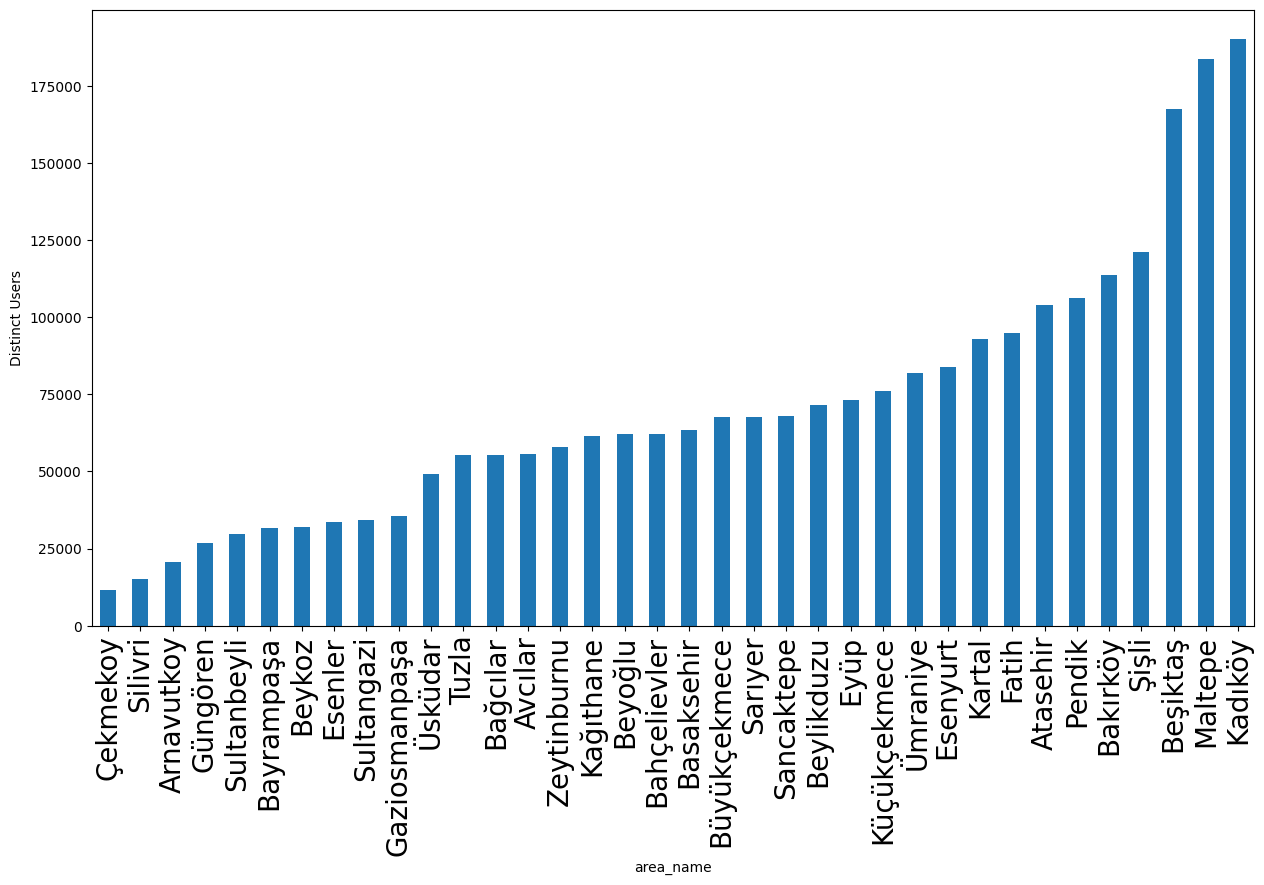

In [80]:
(
    session_data
    .groupby("area_name")
    .size()
    .sort_values()
    .plot(kind="bar", ylabel="Distinct Users", figsize=(15,8))
)

for label in plt.gca().get_xticklabels():
    label.set_fontsize(20)

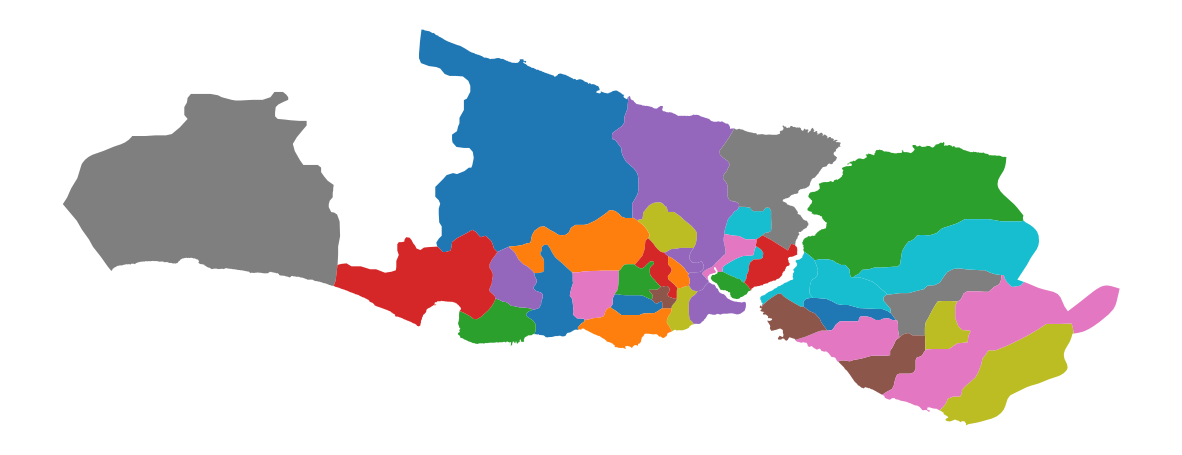

In [24]:
# starting point 
fig, ax = plt.subplots(1,1,figsize=(15,10))
(
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    [area_shapes.columns]
    .plot(column="area_name", ax=ax)
    # .plot()
)

ax.set_axis_off()
plt.show()



# 1st It

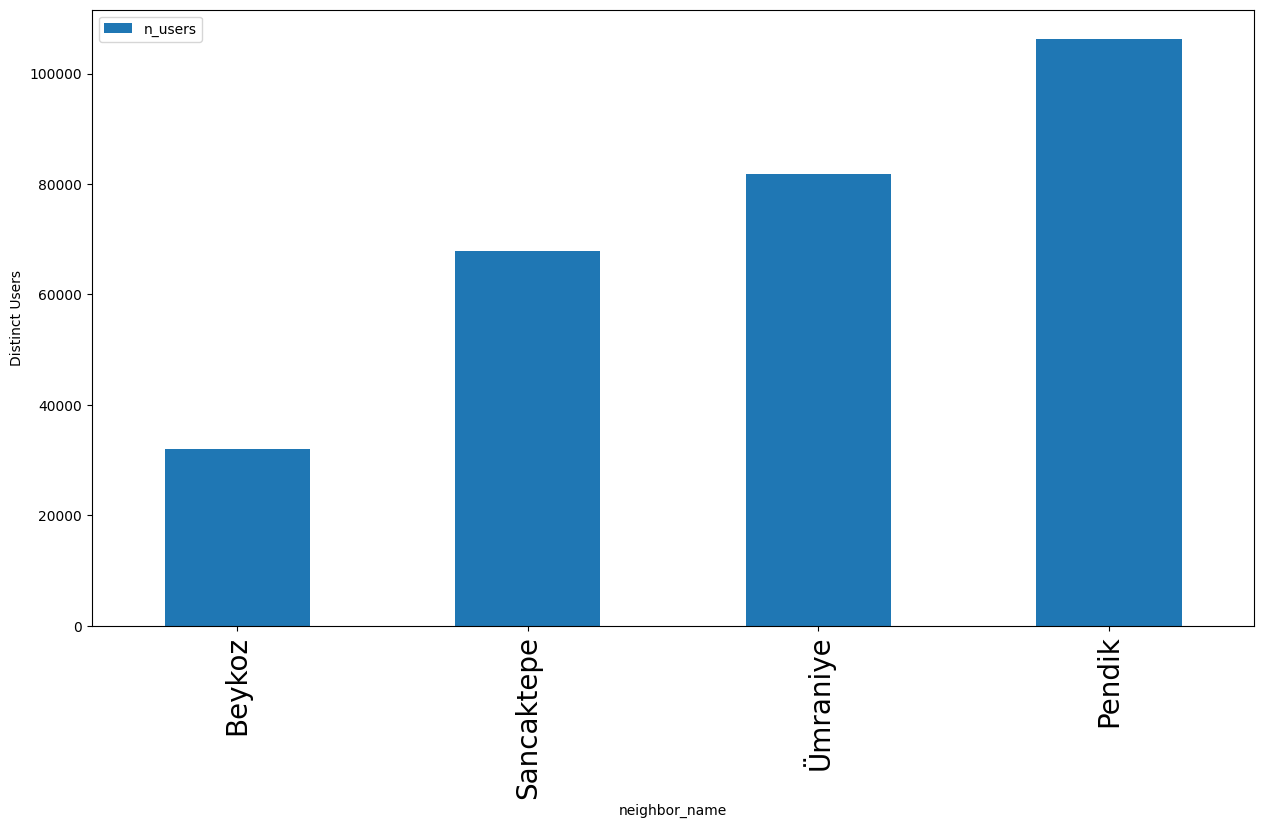

In [65]:
ax = (
    area_neighbors
    .plot(kind="bar", x="neighbor_name", y="n_users", ylabel="Distinct Users", figsize=(15,8))
)

for label in plt.gca().get_xticklabels():
    label.set_fontsize(20)

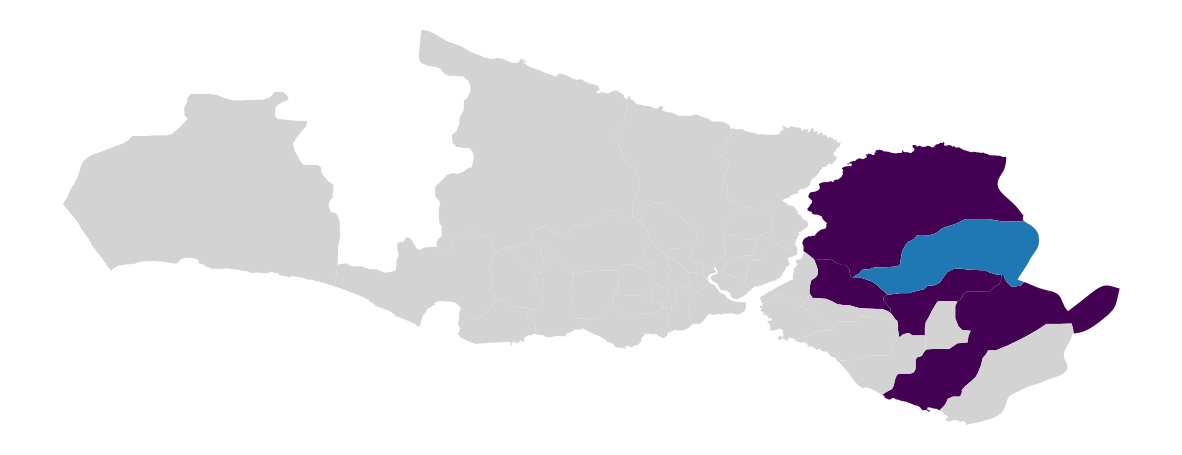

In [46]:

example_shapes = (
    it_shapes
    .assign(
        neighbors = np.where(it_shapes.area_name.isin(area_neighbors.neighbor_name.tolist()),True, np.nan),
        current_area = it_shapes.area_name == "Çekmekoy",
        smallest_neighbor = it_shapes.area_name == "Beykoz"
    )
)


base = (
    example_shapes
    .plot(
        column="neighbors",
        missing_kwds = {
            "color":"lightgrey"
        },
        figsize=(15,8)
    )
)

(
    example_shapes
    .query("current_area")
    .plot(
        column = "current_area"
        , ax=base
    )

)

base.set_axis_off()

/var/folders/3q/wvjxy32x3_n19zqq7b55vjfwfzlf7q/T/ipykernel_52346/2658622743.py:23: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  example_shapes


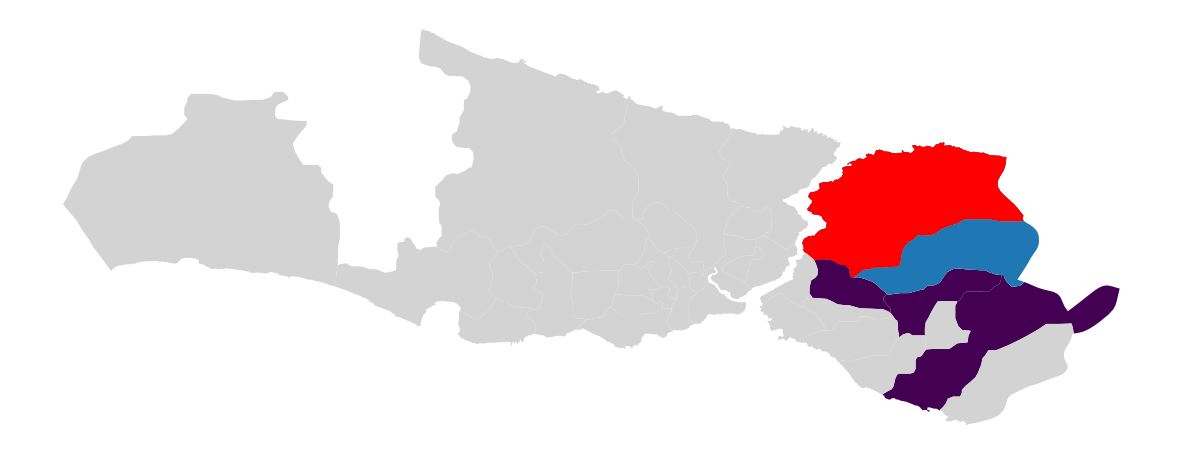

In [48]:
base = (
    example_shapes
    .plot(
        column="neighbors",
        missing_kwds = {
            "color":"lightgrey"
        },
        figsize=(15,8)
    )
)

(
    example_shapes
    .query("current_area")
    .plot(
        column = "current_area"
        , ax=base
    )

)

(
    example_shapes
    .query("smallest_neighbor")
    .plot(
        column = "smallest_neighbor"
        , ax=base
        , color="red"
    )

)



base.set_axis_off()

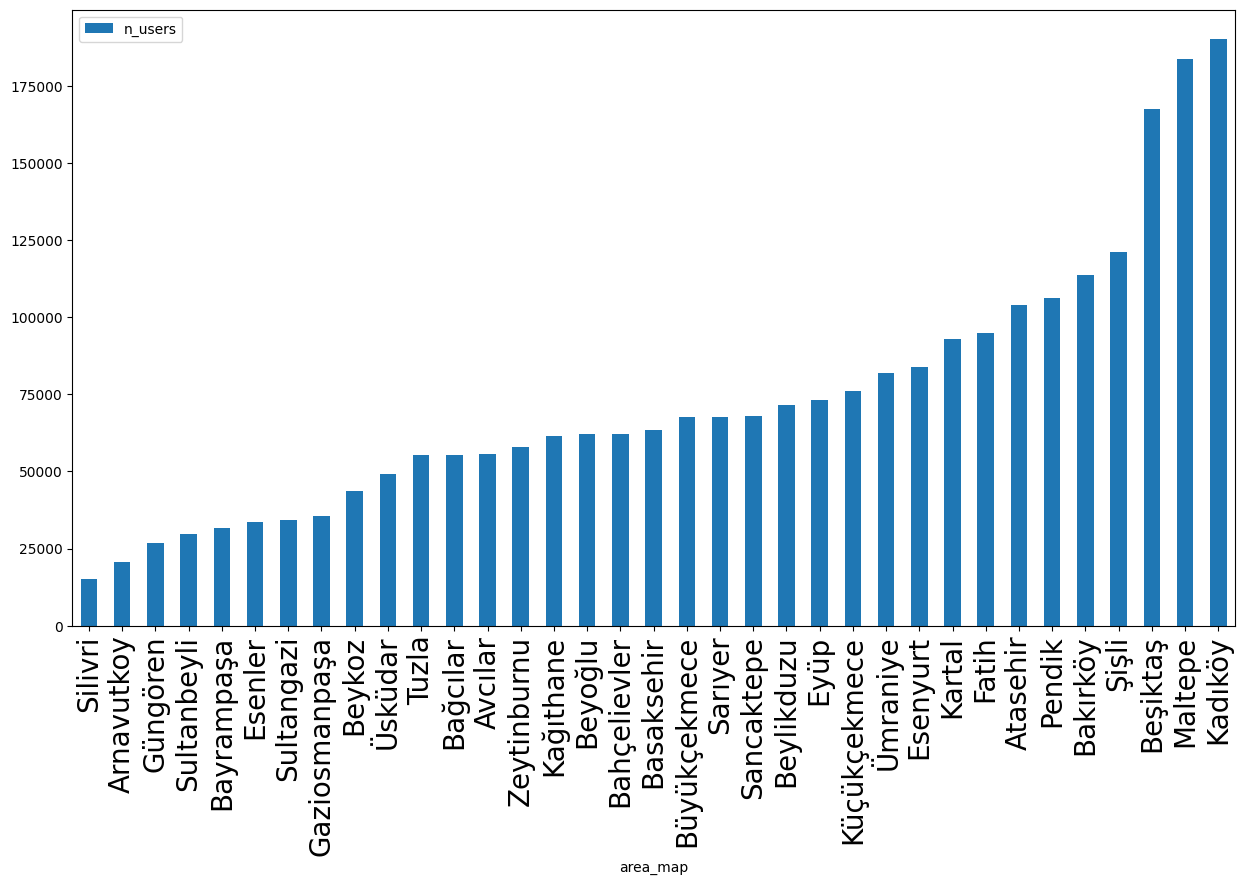

In [81]:
(
        it_df
        .assign(area_map = lambda df: df.area_name.map(area_mapping))  
        .pipe(aggregate_user_data_per_area)
        .plot(kind="bar", x="area_map", y="n_users", figsize=(15,8))
)


for label in plt.gca().get_xticklabels():
    label.set_fontsize(20)


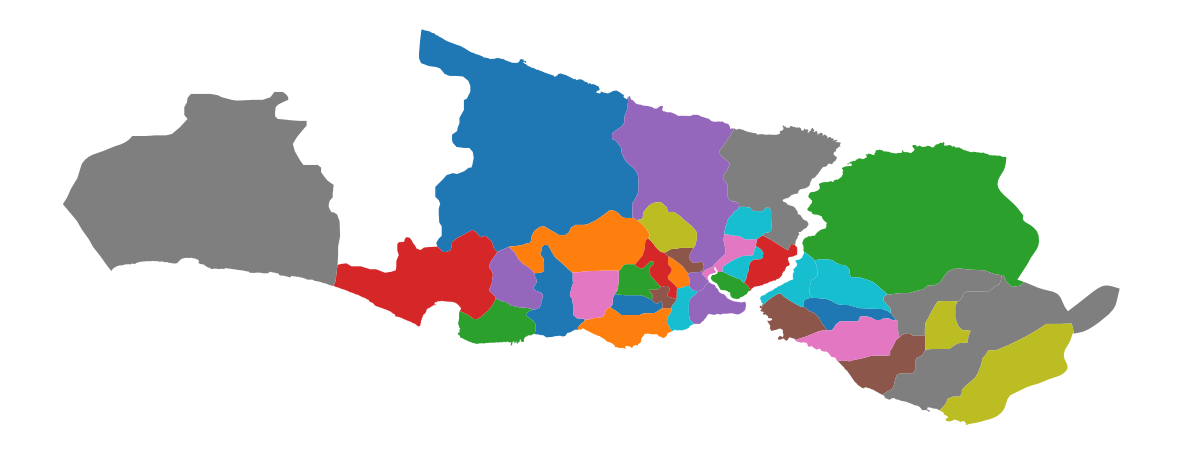

In [79]:
ax = (
    aggregate_shape_data_per_area(it_shapes, area_mapping)
    .plot(column="area_map", figsize=(15,8))
)
ax.set_axis_off()

Text(0.5, 0.98, 'Athens')

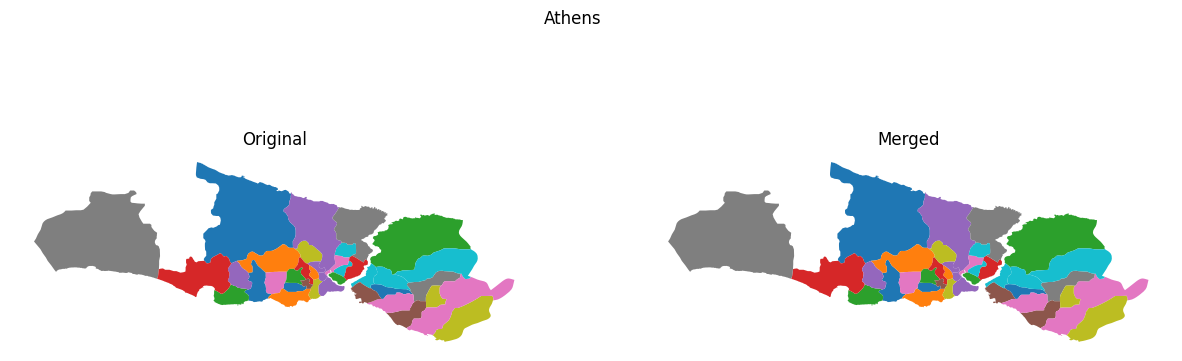

In [76]:
# area_shapes.plot(column="area_name", figsize=(15,15))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

(
    area_shapes
    .sjoin(city_dh_shape, predicate="intersects")
    .plot(column="area_name", ax=ax1)
)
ax1.set_title("Original")
ax1.set_axis_off()

agg_shapes.plot(column="area_map", ax=ax2)
ax2.set_title("Merged")
ax2.set_axis_off()
fig.suptitle("Athens")

# Changelog

## 2023-11-03

- Parametrize sql queries to allow multiple inputs
- 